<h1 style="color: blue;">가. Data loader</h1>

<h2 style="color: green;">1. 데이터 로더 원리</h2>

+ 데이터셋 불러오기: 데이터 로더는 먼저 데이터셋을 불러옵니다. 이때 데이터셋은 일반적으로 디스크 상의 파일로 저장되어 있습니다.
<br></br>
+ 전처리 : 데이터셋을 불러온 후에는 전처리를 수행합니다. 예를 들어, 이미지 데이터를 사용하는 경우, 이미지를 리사이징하거나 색상을 보정하는 등의 작업이 필요할 수 있습니다.
<br></br>
+ 배치 처리 : 전처리된 데이터셋은 배치 단위로 처리됩니다. 배치란 한 번에 처리되는 데이터의 수를 의미합니다. 배치를 사용하면 데이터를 병렬 처리할 수 있으므로 학습 속도가 향상됩니다.
<br></br>
+ 무한 반복 : 데이터 로더는 무한히 반복될 수 있어야 합니다. 이는 학습을 계속 수행할 수 있도록 하는 기능입니다. 무한 반복을 구현하기 위해서는, 데이터셋의 끝에 도달하면 다시 처음부터 데이터를 불러와야 합니다.
<br></br>
+ 병렬 처리 : 데이터 로더는 병렬 처리가 가능해야 합니다. 이는 GPU와 같은 하드웨어 자원을 최대한 활용하여 학습 속도를 높이는 데 중요합니다. 병렬 처리를 구현하기 위해서는, 배치 처리와 함께 멀티 프로세싱 기능을 사용해야 합니다.

<h2 style="color: green;">2. 데이터 로더 특징</h2>

### *여러 파일로 쪼개져서 저장/읽기 기능*

분산 처리 데이터베이스에서는 데이터를 partition(분할) 또는 shard(조각)로 나누어 저장한다. 
이는 병렬 처리에 유리한 구조이기 때문에 가급적 여러 파일인 형태를 그대로 유지하는 것이 좋다 (repartition에도 시간 비용이 들어가기 때문) 또한 data shuffle이 제공되어야 한다. 

### 샤딩(Sharding)
같은 테이블 스키마를 가진 데이터를 다수의 데이터베이스에 분산하여 저장하는 방법을 의미합니다. 하나의 DB에 데이터가 늘어나면 용량 이슈도 생기고, 느려지는 CRUD(Create, Read, Update, Delete)는 자연스레 서비스 성능에 영향을 주게 됩니다. 그래서 DB 트래픽을 분산할 목적으로 샤딩을 고려해 볼 수 있습니다.

#### Modular sharding
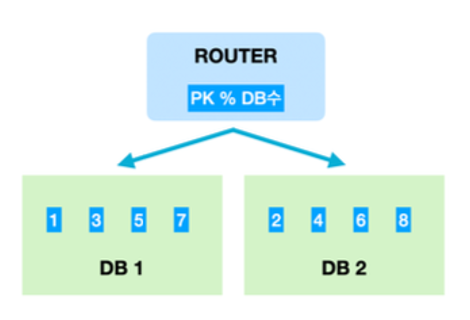
모듈러샤딩은 PK를 모듈러 연산한 결과로 DB를 특정하는 방식입니다.
간략한 장단점은 아래와 같습니다. 

+ 장점 : 레인지샤딩에 비해 데이터가 균일하게 분산됩니다.
+ 단점 : DB 추가 증설하는 과정에서 이미 적재된 데이터의 재정렬이 필요합니다.

모듈러샤딩은 데이터량이 일정 수준에서 유지될 것으로 예상되는 데이터 성격을 가진 곳에 적용할 때 어울 리는 방식입니다.

#### Range sharding
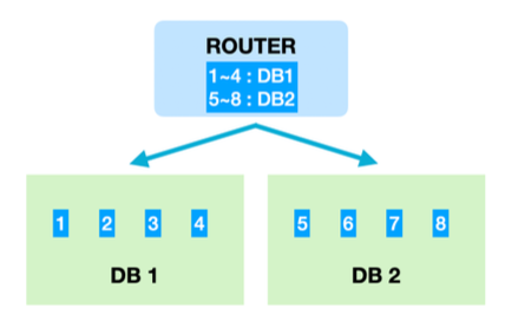
레인지샤딩은 PK의 범위를 기준으로 DB를 특정하는 방식입니다.
간략한 장단점은 아래와 같습니다.

+ 장점 : 모듈러샤딩에 비해 기본적으로 증설에 재정렬 비용이 들지 않습니다.
+ 단점 : 일부 DB에 데이터가 몰릴 수 있습니다.

분산처리를 했는데 이런 상황이 발생하면 또다시 부하분산을 위해 해당 DB를 쪼개 재정렬하는 작업이 필 요하고, 반대로 트래픽이 저조한 DB는 통합작업을 통해 유지비용을 아끼도록 관리해야 합니다.

### *간단한 Key Value 구조*

Key value 구조의 장점은 명확하다. 개발적으로는 데이터 집합 내의 요소들을 key 로 구분하여 알아보기 쉽게 해주며, 자료구조적으로는 O(1)에 가까운 접근 시간을 가진다. 즉 알아보기도 쉽고 사용하기도 쉬우면서 심지어 매우 빠르다.

### *Lazy data loading (메모리 보호)*

메모리가 TB급이 아니라면 학습 데이터 전체를 메모리에 업로드하는 것이 불가능하다. 
따라서 학습에 필요한 부분만 로드하는 기능이 필요하다.

### *IO 병목을 막기 위한 데이터 캐시*

모든 데이터를 메모리에 로드하고 사용할 수 없기 때문에 반드시 학습중간에 IO로딩을 거쳐야한다. 
이 과정에서 IO 로딩 속도 문제로 병목이 발생하므로 IO 로딩 병렬화와 캐시 기능이 제공되어야 한다. 

### *데이터 Custom transform을 유연하게 적용하는 기능*

데이터 변형에는 문자열 형식의 label을  정수형인 index로 바꾸는 정적인 변환 뿐만 아니라
 image augmentation, NLP token masking 같은 동적인 변환도 존재한다. 

데이터 로더를 만드는 과정에서 동적 변환이 쉽게 지원되도록 구현해야 한다. Pytorch에서 변형을 제공하는 클래스를 만들어 전처리 한다.

<h2 style="color: green;">3. 데이터 로더 특징</h2>

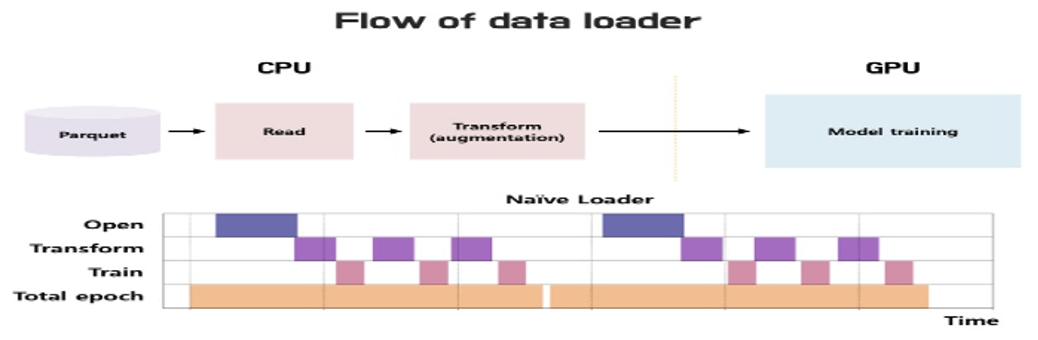
순차적으로 이루어지는 경우 실행 시간을 그래프를 그려보면 학습 시간 전체는 각 과정이 소요하는 시간의 합 이라고 할 수 있다.

학습 시간을 단축시키기 위해서 파일 open 과정과 transform 과정에 소모되는 시간을 단축시키는 것이 중요하다.
GPU에서 모델 학습이 이루어지기 때문에 CPU는 학습을 위한 데이터 준비를 병렬적으로 준비해야 한다. 

<h2 style="color: green;">4. CPU와 GPU 디자인 목적과 구조</h2>

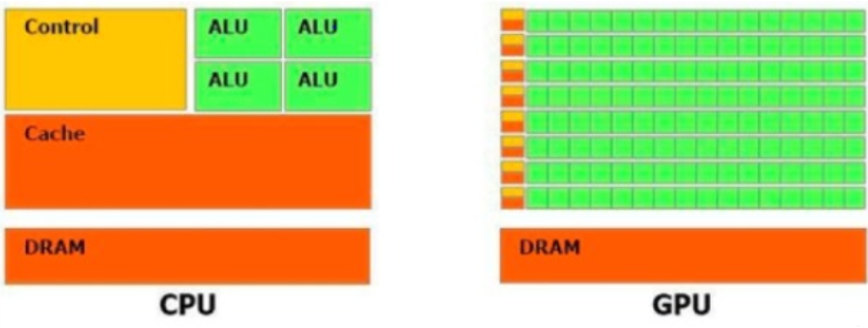

### *CPU*

CPU는 중앙 처리 장치입니다. 컴퓨터 시스템의 두뇌로서, 작업 수행, 데이터 관리, 프로그램 실행 등과 같은 모든 처리를 담당합니다. CPU는 매우 다목적으로 설계되어 있으며, 여러 작업을 처리하고 다양한 유형의 프로그램을 실행할 수 있습니다. 하지만, CPU는 느리고 복잡한 계산을 수행할 때 한계가 있습니다.

+ 복잡한 계산을 코어 갯수 만큼씩 처리한다. 예로 복잡한 팩토리얼 계산식을 2개 계산해야한다고 가정하면 CPU로 계산을 해주면 빨리할 수 있다. 
+ 단점 간단하고 많은 계산식은 오래 걸림

### *GPU*
GPU는 그래픽 처리 장치입니다. 기본적으로 그래픽 처리 장치는 컴퓨터에 설치된 이미지, 비디오, 게임 등의 그래픽 미디어를 처리하는 데 사용됩니다. 그러나 이러한 그래픽 처리 능력을 기반으로하여 과학, 기술 및 기타 계산 분야에서 병렬 처리 및 복잡한 계산 작업을 수행하기 위해 사용됩니다. GPU는 대규모 병렬 처리를 처리하는 데 최적화되어 있으며, 많은 계산 작업을 동시에 수행할 수 있습니다. 이로 인해 GPU는 CPU에 비해 훨씬 빠른 처리 속도를 보입니다.

+ 간단한 아주 많은 계산식을 동시에 빠르게 처리 가능. 예로 1000개의 덧셈식을 한번에 병렬로 처리가 가능
+ 단점 초기에 알고리즘을 하드웨어 병렬로 부여해 주어야하고 복잡한 식을 입력하면 도리어 CPU 연산속도 보다 느려질 수 있다.

<h1 style="color: blue;">2. PyTorch</h1>

<h2 style="color: green;">1. PyTorch 정의</h2>

PyTorch란? Python을 염두에 두고 머신 러닝 프로젝트를 위해 설계된 오픈 소스 라이브러리입니다. 
자동 차별화, 텐서 계산 및 GPU 가속을 전문으로 합니다.

따라서 딥 러닝과 같은 최첨단 머신 러닝 애플리케이션에 매우 적합합니다. 

PyTorch는 Python의 customizability 때문에 연구원 사이에서 특히 대중적입니다. Python을 사용하면 맞춤형 데이터계층 및 네트워크아키텍처를 쉽게 만들 수 있습니다.

<h2 style="color: green;">2. PyTorch - Tensor</h2>

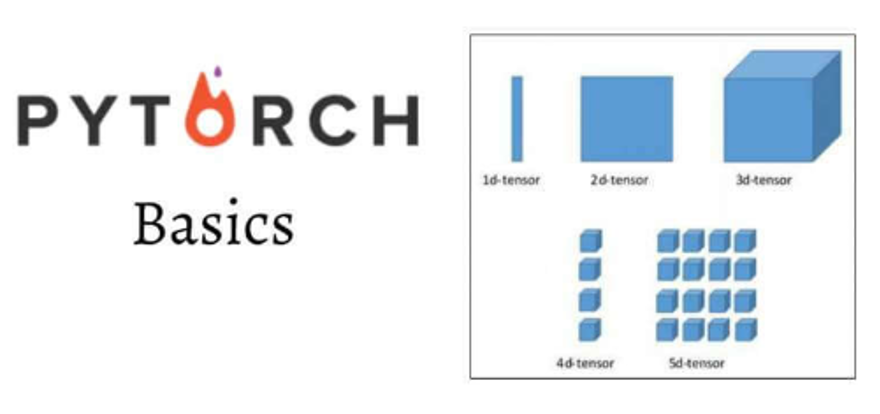

텐서(tensor)는 배열(array)이나 행렬(matrix)과 매우 유사한 특수한 자료구조 입니다. 

PyTorch에서는 텐서를 사용하여 모델의 입력과 출력뿐만 아니라 모델의 매개변수를 부호화(encode)합니다.

GPU나 다른 연산 가속을 위한 특수한 하드웨어에서 실행할 수 있다는 점을 제외하면, 텐서는 NumPy의 ndarray와 매우 유사합니다. 만약 ndarray에 익숙하다면 Tensor API를 바로 사용할 수 있습니다.

In [5]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import numpy as np

<h2 style="color: green;">3. PyTorch 기본</h2>

In [16]:
#PyTorch - 텐서 기본 실습
data = [[1,2], [3,4]]
x_data = torch.tensor(data)
print(x_data)

#NumPy 배열로부터 생성하기
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])


- torch.tensor()는 입력 텐서를 복사하여 새로운 텐서를 만듭니다. 이 함수는 항상 새로운 메모리를 할당하므로, 원본 데이터와의 메모리 공유가 이루어지지 않습니다.

- torch.from_numpy() 함수는 NumPy 배열을 PyTorch 텐서로 변환할 때, 원본 데이터와의 메모리 공유를 유지합니다.

In [17]:
x_ones = torch.ones_like(x_data) 
print(f"ones Tensor : \n{x_ones}")
# torch.ones_like()주어진 입력 텐서와 동일한 크기의 텐서를 생성하고 모든 요소를 1로 체우면됩니다. 

x_rand = torch.rand_like(x_data, dtype=torch.float) # x_data 속성을 덮어씁니다.
print(f'Random Tensor : \n{x_rand}')
# torch.rand_like() 주어진 입력 텐서와 동일한 크기의 텐서를 생성하고 모든 요소를 랜덤한 값으로 채웁니다. 그리고 타입 지정하면 그 타입으로 변경됩니다.
# 0과 1사이의 랜덤한 값으로 초기화 되고 데이터 타입 유형은 dtype=torch.float 지정됩니다. 

ones Tensor : 
tensor([[1, 1],
        [1, 1]])
Random Tensor : 
tensor([[0.5858, 0.5269],
        [0.1209, 0.3694]])


In [31]:
# 무작위 또는 상수 값을 사용하기 
shape = (2,3,)
rand_tensor = torch.rand(shape) * 10 # 0 ~ 10 
ones_tensor = torch.ones(shape)
#torch.ones_like()는 인자값이 numpy배열 형식, ones는 shape() 형태
zeros_tensor = torch.zeros(shape)

print("rand_tensor \n", rand_tensor)
print("ones_tensor \n", ones_tensor)
print("zeros_tensor \n" , zeros_tensor)

rand_tensor 
 tensor([[9.7428, 0.7949, 9.2846],
        [4.2647, 0.8722, 5.5607]])
ones_tensor 
 tensor([[1., 1., 1.],
        [1., 1., 1.]])
zeros_tensor 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [19]:
# 유효 범위를 최소값 얼마 부터 ~ 최대값 얼마까지 6 ~ 10 
shape_temp = (5,6)
min_val = 6
max_val = 10
rand_tensor_temp = torch.rand(shape_temp) * (max_val - min_val) + min_val
print(rand_tensor_temp)

tensor([[8.1686, 7.7318, 9.7232, 7.9063, 7.8081, 6.7988],
        [7.3621, 6.8672, 6.8544, 8.7902, 7.0330, 7.5629],
        [7.6309, 9.3189, 7.0706, 7.7091, 7.2001, 6.8817],
        [6.5914, 6.8865, 6.8073, 6.1137, 7.8701, 6.8426],
        [9.5945, 7.0111, 7.6923, 7.0921, 7.4478, 8.4419]])


In [20]:
tensor_val = torch.rand(3,4)

# 디바이스 정보 가져오기 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# tensor_val.to("cuda")

# 디바이스 변경하고자 하는경우 
# 텐서의 디바이스를 변경하려면 to() 메서드를 사용할 수 있습니다. 이 메서드는 새로운 디바이스로 텐서를 이동시킵니다.
# EX) model.to(device)

print(f"Shape of tensor : {tensor_val.shape}")
print(f"Data type of tensor {tensor_val.dtype}")
print(f"Device tensor is stored on : {tensor_val.device}")

cpu
Shape of tensor : torch.Size([3, 4])
Data type of tensor torch.float32
Device tensor is stored on : cpu


In [21]:
#표준 인덱싱과 슬라이싱
tensor_1 = torch.ones(4,4)
tensor_1[:3] = 0
print(tensor_1)

tensor_2 = torch.ones(4,4)
tensor_2[:,1] =2
print(tensor_2)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])
tensor([[1., 2., 1., 1.],
        [1., 2., 1., 1.],
        [1., 2., 1., 1.],
        [1., 2., 1., 1.]])


In [32]:
# 텐서 합치기
t1 = torch.cat([tensor_1, tensor_1, tensor_1], dim=1)
#dim=0 (행을 기준으로 병합), dim=1 (열을 기준으로 병합)
print(t1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [34]:
#텐서 곱하기(요소별 곱셈)
t_mult = tensor_1.mul(tensor_1)
print(t_mult)
print(tensor_1 * tensor_2)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 2., 1., 1.]])


In [24]:
#행렬 곱
print(tensor_2.matmul(tensor_2))
print(tensor_2 @ tensor_2.T)
#.T는 전치(행과 열을 바꾸는 기능)

tensor([[ 5., 10.,  5.,  5.],
        [ 5., 10.,  5.,  5.],
        [ 5., 10.,  5.,  5.],
        [ 5., 10.,  5.,  5.]])
tensor([[7., 7., 7., 7.],
        [7., 7., 7., 7.],
        [7., 7., 7., 7.],
        [7., 7., 7., 7.]])


In [35]:
#요소 계산(더하기)
t = torch.ones(5)
print(t)
n = t.numpy()
print(n)

t.add_(1)
#t.add(1): 이 연산은 t 텐서의 각 원소에 1을 더한 새로운 텐서를 반환합니다. 기존의 t 텐서는 변경되지 않습니다. 즉, 원래의 t 텐서는 그대로 유지되며, 연산 결과는 새로운 텐서로 반환됩니다.

#t.add_(1): 이 연산은 t 텐서의 각 원소에 1을 더한 결과를 t 텐서 자체에 저장합니다. 따라서, t 텐서가 직접 변경되며, 반환값은 없습니다.


print(t)
print(n)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]
tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]


## 뷰(view) - 원소의 수를 유지하면서 텐서의 크기 변경

In [41]:
"""
파이토치 텐서의 뷰는 넘파이의 Reshape와 같은 역할
Reshape > 텐서의 크기를 변경해주는 역할
"""

t_temp = np.array([[[0,1,2], [3,4,5], [6,7,8], [9,10,11]]])
ft = torch.FloatTensor(t_temp)
print(ft)
print(ft.shape)
#첫 번째 차원의 크기는 1입니다.
#두 번째 차원의 크기는 4입니다.
#세 번째 차원의 크기는 3입니다.

#이제 ft view -> 2차원 텐서로 변경
print(ft.view([-1,3]))  #(?, 3) -> (4,3)
#-1 : 파이토치에서 알아서 채우도록 한다.

print(ft.view([-1,3]).shape)
#view() 메서드를 사용하여 텐서의 차원을 변경하면, -> 데이터를 복사하여 새로운 텐서를 생성하고 이 새로운 텐서는 원래 텐서와 메모리를 공유하지 않는다.

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]]])
torch.Size([1, 4, 3])
tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])
torch.Size([4, 3])


In [43]:
print(ft.view([-1, 1, 3]))
#첫번째 차원 랜덤, 두번째 차원 1개, 마지막 차원 3개로 설정
print(ft.view([-1, 1, 3]).shape)
#-1로 지정하여 첫 번째 차원의 크기가 랜덤으로 설정된 모습

tensor([[[ 0.,  1.,  2.]],

        [[ 3.,  4.,  5.]],

        [[ 6.,  7.,  8.]],

        [[ 9., 10., 11.]]])
torch.Size([4, 1, 3])


In [28]:
"""
스퀴즈 -> 1차원을 제거
스퀴즈는 차원이 1인 경우에는 해당 차원을 제거합니다.
실습 3x1 크기를 가지는 2차원 텐서 생성
"""

ft = torch.FloatTensor([[0], [1], [2]])
print(ft)
print(ft.shape)

tensor([[0.],
        [1.],
        [2.]])
torch.Size([3, 1])


In [29]:
print(ft.squeeze())
print(ft.squeeze().shape)

tensor([0., 1., 2.])
torch.Size([3])


In [30]:
"""
언스퀴즈 - 특정 위치에서 1인 차원을 추가합니다
"""
ft_temp = torch.Tensor([0, 1, 2])
print(ft_temp.shape)

torch.Size([3])


In [44]:
#첫 번째 차원에서 1차원 추가
#인덱스 0
print(ft_temp.unsqueeze(0))
#index(0) : 첫번째 차원에 추가 (1은 두번째, 2는 3번째를 의미한다.)
print(ft_temp.unsqueeze(0).shape)

tensor([[0., 1., 2.]])
torch.Size([1, 3])


In [45]:
print(ft_temp.view(1, -1))
print(ft_temp.view(1, -1).shape)
#앞에서부터 행과 열의 개수를 지정한 대로 view문법으로 배열 정렬

tensor([[0., 1., 2.]])
torch.Size([1, 3])
